In [1]:
import numpy as np
import chess
import chess.pgn
import math
import random
from collections import defaultdict, deque
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import load_model

C_PUCT = 2.8      
model_type = "agressive"
model = load_model(f'{model_type}.keras')

import numpy as np
piece_map = {
    chess.PAWN: 0,
    chess.KNIGHT: 1,
    chess.BISHOP: 2,
    chess.ROOK: 3,
    chess.QUEEN: 4,
    chess.KING: 5
}
def board2tensor_1d(board):
    tensor = np.zeros((12, 64), dtype=np.float32)
    for sq in chess.SQUARES:
        piece = board.piece_at(sq)
        if piece:
            base = piece_map[piece.piece_type]
            if piece.color == chess.BLACK:
                base += 6
            tensor[base, sq] = 1.0
    return tensor.flatten()
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)


class MCTSNode:
    def __init__(self, board, parent=None, eval=0.0, prior=0.0):
        self.board = board.copy()
        self.parent = parent
        self.children = {}
        self.prior = eval
        self.eval = eval
        self.N = 0
        self.W = 0.0
        self.Q = 0.0
        self.is_expanded = False

    def expand(self):
        legal_moves = list(self.board.generate_legal_moves())
        n = len(legal_moves)

        turn = 1.0
        if self.board.turn: 
            turn = -1.0

        tensors = np.zeros((n, 12 * 64), dtype=np.float32)
        for i, move in enumerate(legal_moves):
            self.board.push(move)
            tensors[i] = board2tensor_1d(self.board)
            self.board.pop()

        evals = model.predict(tensors, verbose=0).flatten()
        evals *= turn
        priors = softmax(evals)
        for move, ev, p in zip(legal_moves, evals, priors):
            self.children[move] = MCTSNode(
                board=self.board,
                parent=self,
                eval=ev,
                prior=p
            )

        self.is_expanded = True
        return self.eval

    @staticmethod
    def uct_score(child, parent_N, c_puct=1.5):
        U = c_puct * child.prior * math.sqrt(parent_N + 1e-8) / (1 + child.N)
        return child.Q + U


    def select_child(self):
        parent_N = self.N
        best_move = None
        best_score = -float('inf')

        for move, child in self.children.items():
            score = MCTSNode.uct_score(child, parent_N)
            if score > best_score:
                best_score = score
                best_move = move

        return best_move, self.children[best_move]

    def backpropagate(self, value):
        node = self
        while node is not None:
            node.N += 1
            node.W += value
            node.Q = node.W / node.N
            
            value = -value
            node = node.parent

    def get_policy_value(self):
        policy = self.Q
        if not self.board.turn:  # przywrucenie widoku ze strony białych
            policy *= -1
        return policy


def mcts_search(root, simulations=200):
    for _ in range(simulations):
        node = root

        # Selection
        while node.is_expanded and not node.board.is_game_over():
            move, node = node.select_child()

        # Expansion
        if not node.board.is_game_over():
            value = node.expand()
        else:
            result = node.board.result()
            if result == "1-0":
                value = 5000
            elif result == "0-1":
                value = -5000
            else:
                value = 0

        # Backpropagation
        node.backpropagate(value)


2026-01-06 13:07:05.152708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767701225.162694   32060 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767701225.166368   32060 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767701225.174314   32060 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767701225.174322   32060 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767701225.174324   32060 computation_placer.cc:177] computation placer alr

In [2]:
from collections import deque

def extract_training_data(root):
    queue = deque([root])
    X, Y = [], []

    while queue:
        node = queue.popleft()

        tensor = board2tensor_1d(node.board)
        X.append(tensor)

        # Q-value jako label
        Y.append(node.get_policy_value())

        for child in node.children.values():
            queue.append(child)

    return np.array(X), np.array(Y)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
model = load_model(f'{model_type}.keras')
ITERATIONS = 150
SYMULATIONS = 750
SAVE_INTERVAL = 10

version = 1
historis = []
for iter in range(ITERATIONS):
    root = MCTSNode(chess.Board())
    mcts_search(root, simulations=SYMULATIONS)
    X, Y = extract_training_data(root)

    X = np.array(X)
    Y = np.array(Y).astype(np.float32)
    print("Zebrano przykładów:", X.shape[0])


    X_train, X_val, y_train, y_val = train_test_split(
        X, Y, test_size=0.2, shuffle=True
    )


    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=256,
        verbose=1,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )
    historis.append(history)
    if((iter + 1) % SAVE_INTERVAL == 0):
        model.save(f"models/{model_type}_{version}.keras")
        version += 1





Zebrano przykładów: 15001
Epoch 1/10
32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5458.4305 - mae: 57.0678

2026-01-06 13:11:03.443717: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1106', 32 bytes spill stores, 32 bytes spill loads

2026-01-06 13:11:03.567144: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_521', 636 bytes spill stores, 636 bytes spill loads

2026-01-06 13:11:03.588432: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1106', 160 bytes spill stores, 160 bytes spill loads

2026-01-06 13:11:03.772836: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_521', 912 bytes spill stores, 912 bytes spill loads

2026-01-06 13:11:04.162156: I extern

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 4539.2988 - mae: 51.0232

2026-01-06 13:11:05.693994: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 20 bytes spill stores, 20 bytes spill loads

2026-01-06 13:11:05.870929: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 620 bytes spill stores, 620 bytes spill loads



47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 2253.1072 - mae: 34.9276 - val_loss: 11.9061 - val_mae: 3.0556
Epoch 2/10
 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 316.5615 - mae: 13.6162

2026-01-06 13:11:06.069895: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 924 bytes spill stores, 924 bytes spill loads



47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 208.3711 - mae: 11.2581 - val_loss: 4.6607 - val_mae: 1.4586
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 156.9524 - mae: 9.7902 - val_loss: 3.1553 - val_mae: 1.2247
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 153.5294 - mae: 9.6917 - val_loss: 8.3199 - val_mae: 2.7690
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156.5711 - mae: 9.8149 - val_loss: 12.6405 - val_mae: 3.1729
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 158.7727 - mae: 9.8460 - val_loss: 3.3070 - val_mae: 1.3133
Zebrano przykładów: 15001
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 853.5557 - mae: 22.1474 - val_loss: 52.2908 - val_mae: 7.2312
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 166.1325 - mae: 10.1476 - val_loss: 0.0329 - val_mae: 0.1811
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 156.8148 - mae: 9.8555 - val_loss: 2.6606 - val_mae: 1.6311
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━

2026-01-06 13:55:48.666025: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.00MiB (rounded to 4194304)requested by op 
2026-01-06 13:55:48.666105: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2026-01-06 13:55:48.666117: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 1480, Chunks in use: 1480. 370.0KiB allocated for chunks. 370.0KiB in use in bin. 25.7KiB client-requested in use in bin.
2026-01-06 13:55:48.666122: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 264B client-requested in use in bin.
2026-01-06 13:55:48.666127: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (1024): 	Total Chunks: 2, Chunks in use: 2. 2.2KiB allocated for chunks. 2.2KiB in use in bin. 2.0KiB client-requested in use in bin

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 758, in start

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/ipykernel/utils.py", line 71, in preserve_context

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 614, in shell_main

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_shell

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 366, in execute_request

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 827, in execute_request

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 458, in do_execute

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 663, in run_cell

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_32060/1614126906.py", line 34, in <module>

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 399, in fit

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 241, in function

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in multi_step_on_iterator

  File "/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 125, in wrapper

Out of memory while trying to allocate 4194304 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   21.96MiB
              constant allocation:         0B
        maybe_live_out allocation:   21.21MiB
     preallocated temp allocation:   10.29MiB
  preallocated temp fragmentation:    1.00MiB (9.72%)
                 total allocation:   32.25MiB
Peak buffers:
	Buffer 1:
		Size: 4.00MiB
		Operator: op_type="MatMul" op_name="gradient_tape/sequential_3_1/dense_13_1/MatMul/MatMul" source_file="/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200
		XLA Label: custom-call
		Shape: s8[4194304]
		==========================

	Buffer 2:
		Size: 4.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[1024,1024]
		==========================

	Buffer 3:
		Size: 4.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[1024,1024]
		==========================

	Buffer 4:
		Size: 4.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[1024,1024]
		==========================

	Buffer 5:
		Size: 3.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[768,1024]
		==========================

	Buffer 6:
		Size: 3.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[768,1024]
		==========================

	Buffer 7:
		Size: 3.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[768,1024]
		==========================

	Buffer 8:
		Size: 1.00MiB
		Operator: op_type="MatMul" op_name="gradient_tape/sequential_3_1/dense_13_1/MatMul/MatMul" source_file="/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200
		XLA Label: custom-call
		Shape: f32[256,1024]
		==========================

	Buffer 9:
		Size: 1.00MiB
		Operator: op_type="BiasAddGrad" op_name="gradient_tape/sequential_3_1/dense_13_1/BiasAdd/BiasAddGrad"
		XLA Label: fusion
		Shape: f32[256,1024]
		==========================

	Buffer 10:
		Size: 1.00MiB
		Operator: op_type="MatMul" op_name="sequential_3_1/dense_13_1/MatMul" source_file="/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200
		XLA Label: custom-call
		Shape: f32[256,1024]
		==========================

	Buffer 11:
		Size: 1.00MiB
		Operator: op_type="SelectV2" op_name="sequential_3_1/dropout_6_1/stateless_dropout/SelectV2" source_file="/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200
		XLA Label: fusion
		Shape: f32[256,1024]
		==========================

	Buffer 12:
		Size: 1.00MiB
		Operator: op_type="MatMul" op_name="sequential_3_1/dense_12_1/MatMul" source_file="/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200
		XLA Label: custom-call
		Shape: f32[256,1024]
		==========================

	Buffer 13:
		Size: 768.0KiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[256,768]
		==========================

	Buffer 14:
		Size: 256.0KiB
		Operator: op_type="GreaterEqual" op_name="sequential_3_1/dropout_6_1/stateless_dropout/GreaterEqual" source_file="/home/krzysztof/miniconda3/envs/ChessConda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200
		XLA Label: fusion
		Shape: pred[65536,4]
		==========================

	Buffer 15:
		Size: 64.0KiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[1024,16]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_3612849]

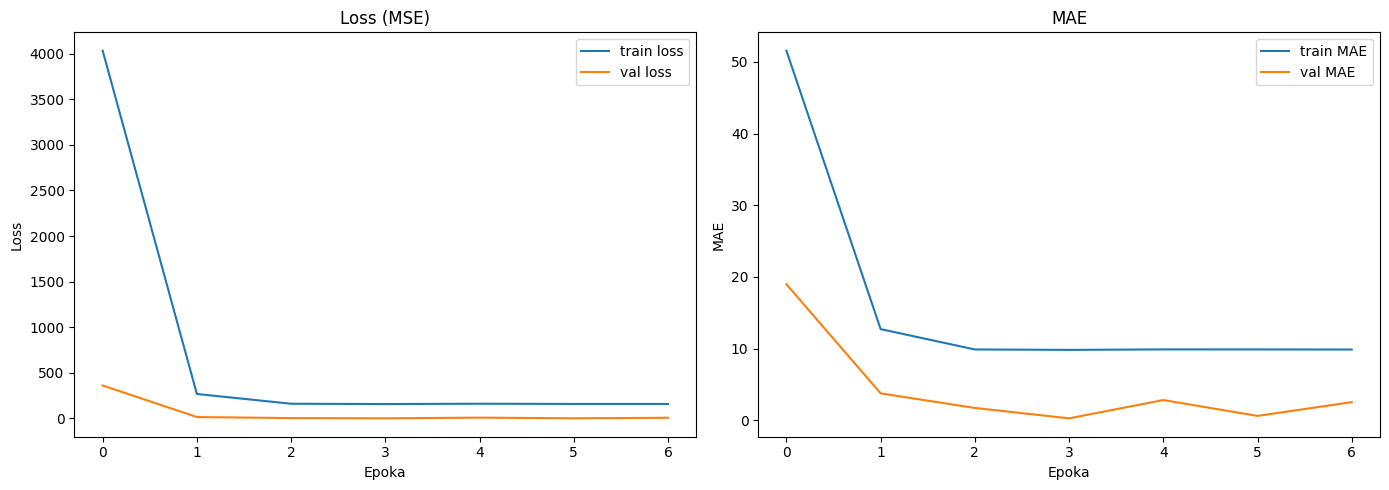

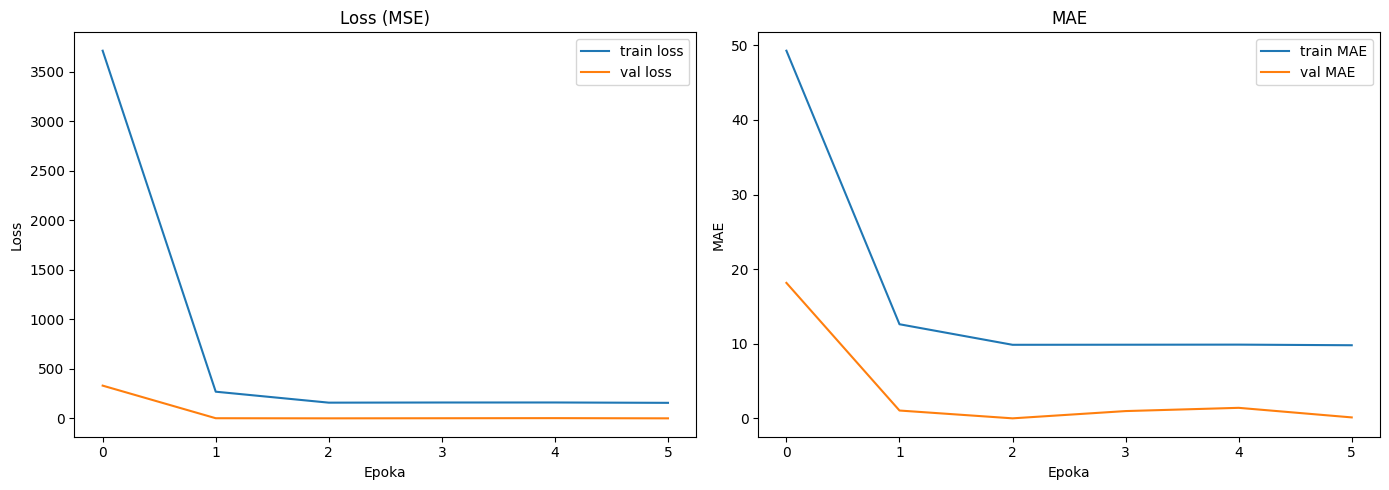

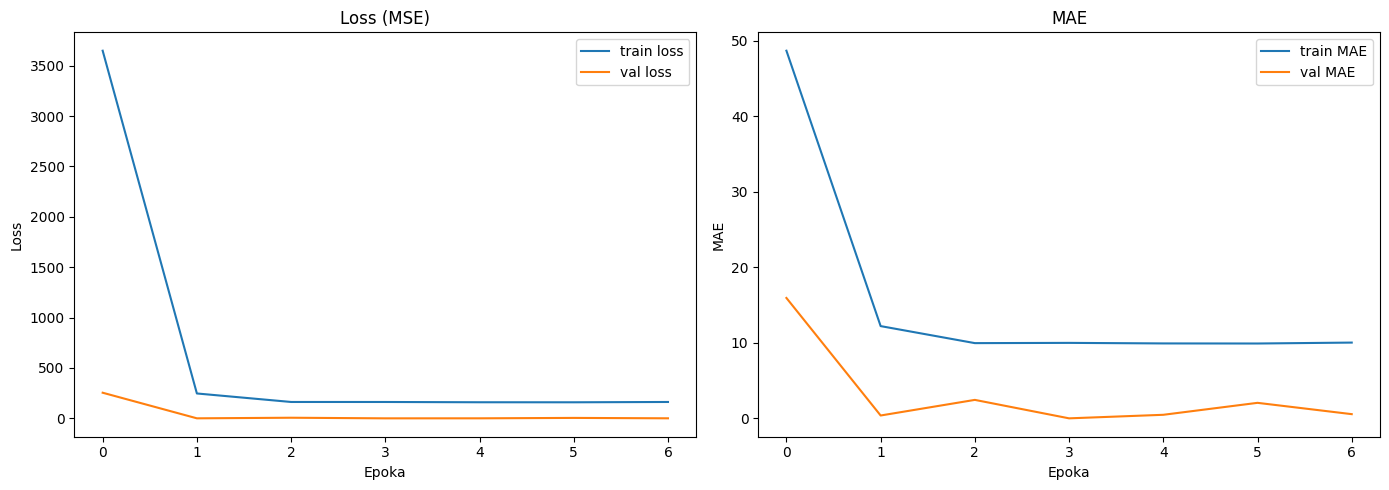

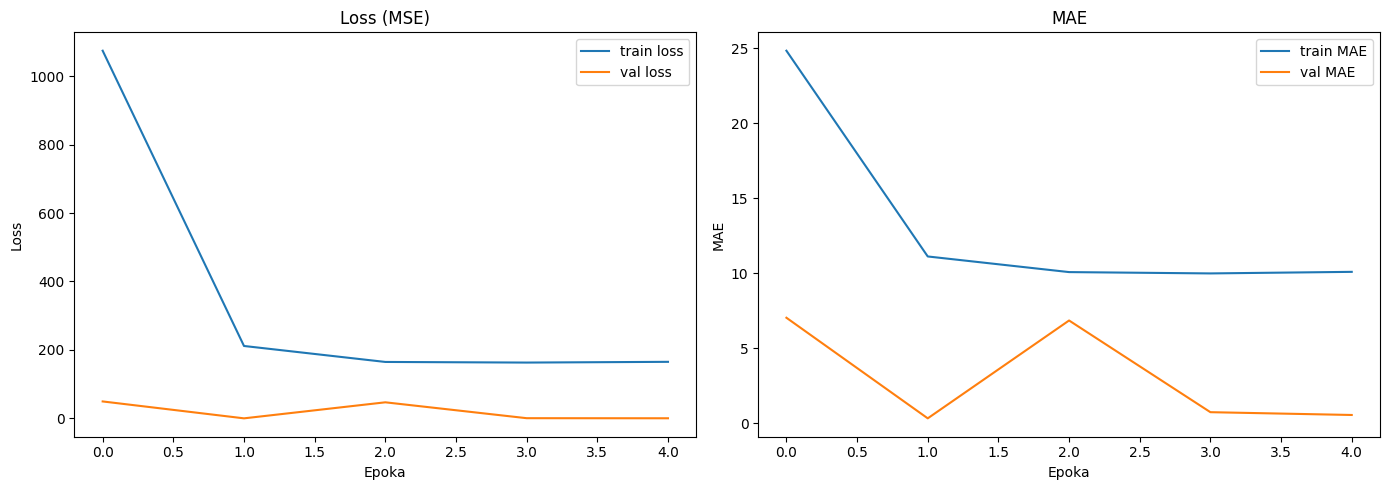

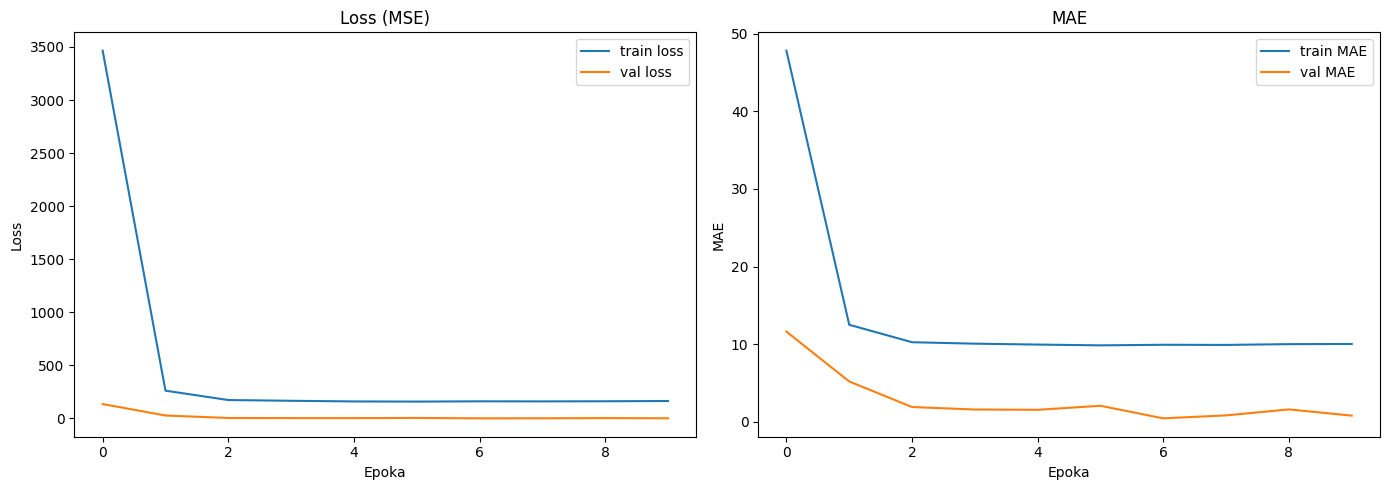

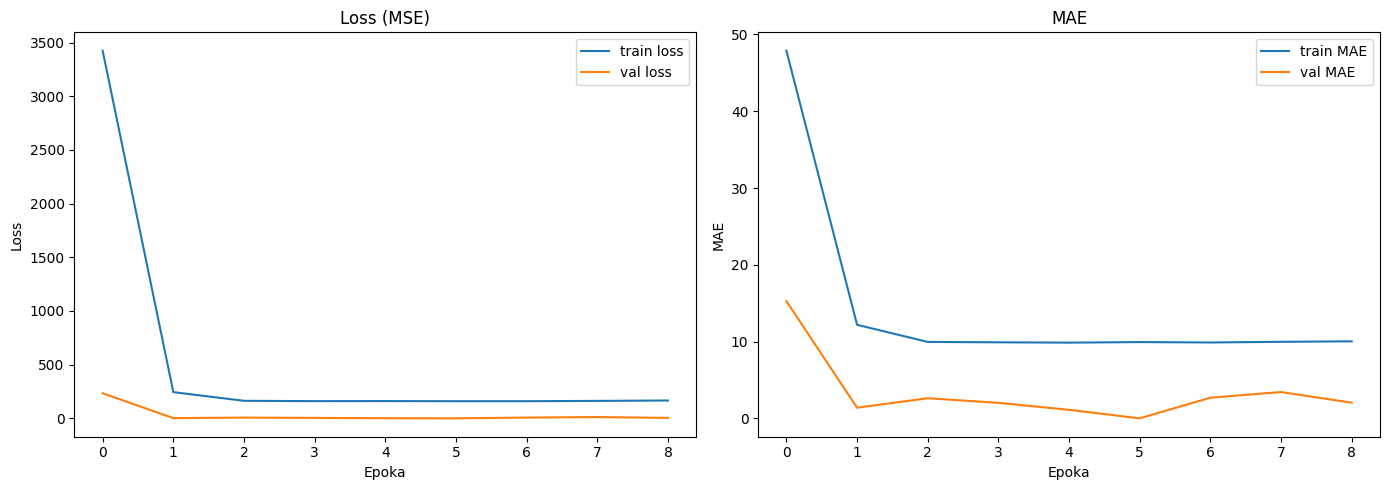

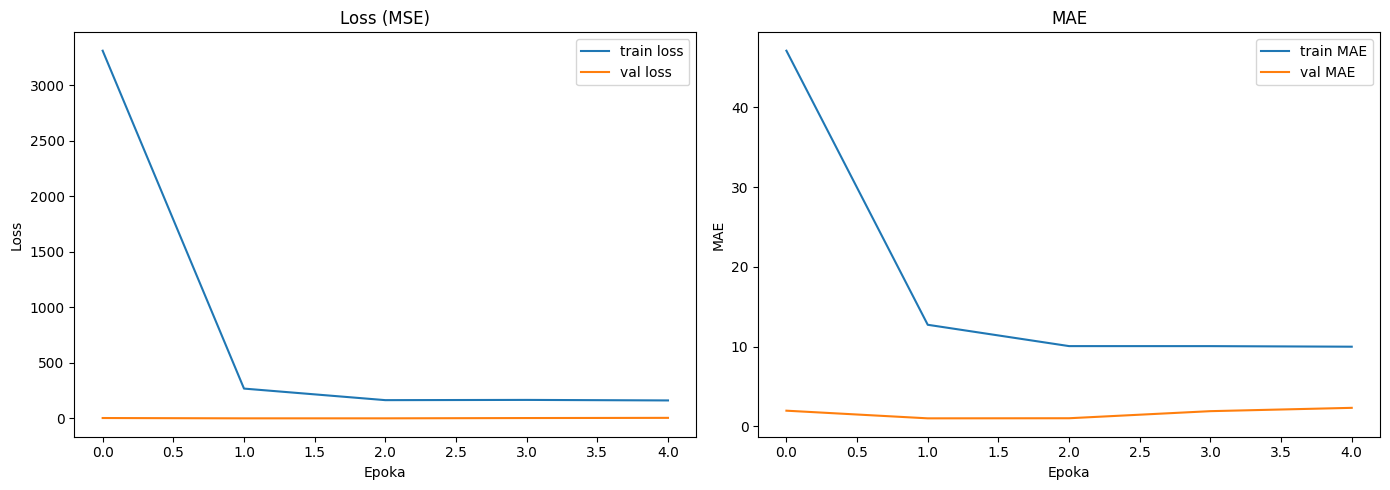

In [7]:
for i in range(1,8):
    history = historis[10 * i]
    plt.figure(figsize=(14,5))
    # ------ Loss ---------
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.title("Loss (MSE)")
    plt.xlabel("Epoka")
    plt.ylabel("Loss")
    plt.legend()

    # ------ MAE ----------
    plt.subplot(1,2,2)
    plt.plot(history.history["mae"], label="train MAE")
    plt.plot(history.history["val_mae"], label="val MAE")
    plt.title("MAE")
    plt.xlabel("Epoka")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()